# How to Use XGBoost for Time Series Forecasting

* Ref: [https://machinelearningmastery.com/xgboost-for-time-series-forecasting/](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/)
* Data: [https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv)


## XGBoost
* 是一種 stochastic gradient boosting ensemble algorithm
  * gradient boosting 又叫做 tree boosting
  * 新的 tree 會修正原先已存在的 tree 中的 error
    * 因為 boost 就是用來學上一個沒學好的部分
* 可以用來做 regression 和 classification
  * 快又準
* 也可以拿來做 time series forecast
  * time series 要先轉換格式成 supervised learning 的
    * 很吃格式的，所以格式一定要對才能跑
  * 只能用 walk-forward validation 的方法
    * 因為是 time series 所以不可以用 k-fold cross validation 等會 randomize dataset 的方式

In [85]:
import xgboost
xgboost.__version__

'0.90'

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display

## 1. Load data

In [87]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [88]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/daily-total-female-births.csv',
                 header=0,
                 index_col=0)
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Births  365 non-null    int64
dtypes: int64(1)
memory usage: 5.7+ KB


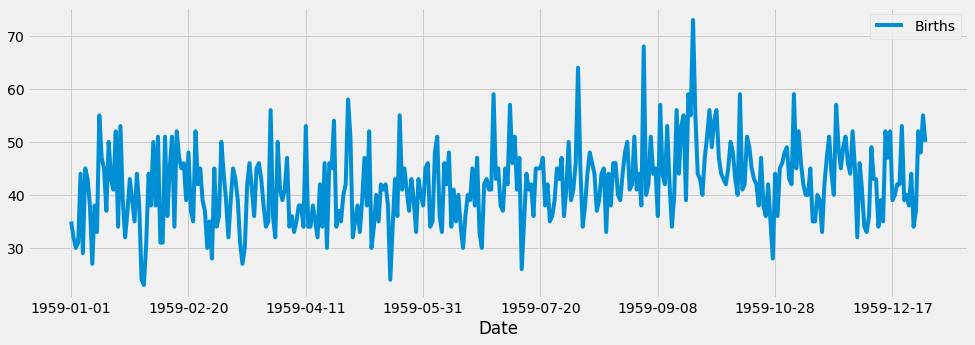

In [90]:
# Show the time series distribution
fig, ax = plt.subplots(figsize=(15, 5))
df.plot(ax=ax)
plt.show()

## 2. Build model

In [91]:
# 把 time series dataset 轉成 supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    # print('type(data)=', type(data)) # 輸入的 data 是 numpy array
    # n_vars = 1 if type(data) is list else data.shape[1] # n_vars 就是輸入的 data 有幾個欄位, 但是這邊沒用到

    df = pd.DataFrame(data)

    cols = []
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1): # 從 n_in 遞減到 -1, 不包含 0
        cols.append(df.shift(i)) # index 不動，數據往下移動 i row，會在頂端造成 NaN

    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)) # index 不動，數據往上移動 i row，會在尾端造成 NaN

    # put it all together
    df_agg = pd.concat(cols, axis=1)
    display(df_agg.head())

    # drop NaN
    if dropna:
        df_agg.dropna(inplace=True) # 因為做了 shift() 所以有些儲存格會是空的，要把這些丟掉

    # print('type(df_agg.values)=', type(df_agg.values))

    return df_agg.values # 傳回的是 numpy array

In [92]:
def train_test_split(data, n_test):
  # data 是一個 numpy array
  # 倒數 n_test row 是 test sample 其他是 train sample
  return data[:-n_test, :], data[-n_test:, :]

In [93]:
from xgboost import XGBRegressor

def xgboost_forecast(train, X_test):
    train = np.asarray(train) # sklearn 吃的是 numpy array

    X_train, y_train = train[:, :-1], train[:, -1]
    print('X_train:\n', type(X_train), X_train.shape, '\n', X_train) # X_train 是 2d numpy array
    print('y_train:\n', type(y_train), y_train.shape, '\n', y_train) # y_train 是 1d numpy array, 長得像 list 那樣

    # build model & fit
    model = XGBRegressor(objective='reg:squarederror', # 這個是 loss function
                         n_estimators=1000) # 用多一點的樹才不會 under learning
    model.fit(X_train, y_train)

    print('X_test:\n', type(X_test), X_test.shape, '\n', X_test) # X_test 是 1d numpy array
    print('[X_test]:\n', [X_test]) # [X_test] 是個 list, 元素是 1d numpy array
    # make one-step prediction
    # yhat = model.predict([X_test]) # 注意輸入參數的格式 XGBoost v0.9 可以用 list 當參數

    # XGBoost v 1.2.0 中 predict() 要用 2d numpy array (1 row, n_lags column)
    print(X_test.reshape(1, -1).shape)
    print(X_test.reshape(1, -1))
    yhat = model.predict(X_test.reshape(1, -1))
    
    return yhat[0]

In [94]:
from sklearn.metrics import mean_absolute_error

def walk_forward_validation(data, n_test): # 輸入 numpy array 還有指定要預測倒數幾個 rows
    predictions = []

    # split the data
    train, test = train_test_split(data, n_test)

    # train 和 test 都是 2d numpy array, column 數目是 lags + 1
    print('train:\n', type(train), train.shape, '\n', train)
    print('test:\n', type(test), test.shape, '\n', test)

    history = [x for x in train] # 每個元素是一個有 lags + 1 個欄位的 1d numpy array
    print('history:\n', history)

    # step over each timestep in test set
    for i in range(len(test)):
        X_test, y_test = test[i, :-1], test[i, -1] # 每個 row 的最後一個欄位是 y 其他欄位是 X
        print('X_test:\n', type(X_test), X_test) # X_test 是 2d numpy array
        print('y_test:\n', type(y_test), y_test) # y_test 只是一個數

        yhat = xgboost_forecast(history, X_test) # 每次只預測下一個值
        predictions.append(yhat) # 把預測到的結果加入
        history.append(test[i]) # 把真正的結果加入到 history 中，下個循環會用到

        print('>>> expected = %.2f, predicted = %.2f' % (y_test, yhat))

    error = mean_absolute_error(test[:, -1], predictions)

    return error, test[:, -1], predictions

## 3. Forecast

In [95]:
data = df.values
print(type(data), data.shape) # 365 個 rows, 1 個 column

<class 'numpy.ndarray'> (365, 1)


In [96]:
data = series_to_supervised(data, n_in=6) # 用 6 個 lags 來預測，所以 data 會有 7 個欄位: t-6, t-5, t-4, t-3, t-2, t-1, t
print(data)

,0,0,0,0,0,0,0
0,NaN,NaN,NaN,NaN,NaN,NaN,35
1,NaN,NaN,NaN,NaN,NaN,35.0,32
2,NaN,NaN,NaN,NaN,35.0,32.0,30
3,NaN,NaN,NaN,35.0,32.0,30.0,31
4,NaN,NaN,35.0,32.0,30.0,31.0,44


[[35. 32. 30. ... 44. 29. 45.]
 [32. 30. 31. ... 29. 45. 43.]
 [30. 31. 44. ... 45. 43. 38.]
 ...
 [40. 38. 44. ... 37. 52. 48.]
 [38. 44. 34. ... 52. 48. 55.]
 [44. 34. 37. ... 48. 55. 50.]]


In [97]:
mae, y, yhat = walk_forward_validation(data, 12) # 預測倒數 12 個 row

train:
 <class 'numpy.ndarray'> (347, 7) 
 [[35. 32. 30. ... 44. 29. 45.]
 [32. 30. 31. ... 29. 45. 43.]
 [30. 31. 44. ... 45. 43. 38.]
 ...
 [34. 39. 35. ... 47. 52. 39.]
 [39. 35. 52. ... 52. 39. 40.]
 [35. 52. 47. ... 39. 40. 42.]]
test:
 <class 'numpy.ndarray'> (12, 7) 
 [[52. 47. 52. 39. 40. 42. 42.]
 [47. 52. 39. 40. 42. 42. 53.]
 [52. 39. 40. 42. 42. 53. 39.]
 [39. 40. 42. 42. 53. 39. 40.]
 [40. 42. 42. 53. 39. 40. 38.]
 [42. 42. 53. 39. 40. 38. 44.]
 [42. 53. 39. 40. 38. 44. 34.]
 [53. 39. 40. 38. 44. 34. 37.]
 [39. 40. 38. 44. 34. 37. 52.]
 [40. 38. 44. 34. 37. 52. 48.]
 [38. 44. 34. 37. 52. 48. 55.]
 [44. 34. 37. 52. 48. 55. 50.]]
history:
 [array([35., 32., 30., 31., 44., 29., 45.]), array([32., 30., 31., 44., 29., 45., 43.]), array([30., 31., 44., 29., 45., 43., 38.]), array([31., 44., 29., 45., 43., 38., 27.]), array([44., 29., 45., 43., 38., 27., 38.]), array([29., 45., 43., 38., 27., 38., 33.]), array([45., 43., 38., 27., 38., 33., 55.]), array([43., 38., 27., 38., 33., 

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


X_test:
 <class 'numpy.ndarray'> (6,) 
 [52. 47. 52. 39. 40. 42.]
[X_test]:
 [array([52., 47., 52., 39., 40., 42.])]
(1, 6)
[[52. 47. 52. 39. 40. 42.]]
>>> expected = 42.00, predicted = 39.67
X_test:
 <class 'numpy.ndarray'> [47. 52. 39. 40. 42. 42.]
y_test:
 <class 'numpy.float64'> 53.0
X_train:
 <class 'numpy.ndarray'> (348, 6) 
 [[35. 32. 30. 31. 44. 29.]
 [32. 30. 31. 44. 29. 45.]
 [30. 31. 44. 29. 45. 43.]
 ...
 [39. 35. 52. 47. 52. 39.]
 [35. 52. 47. 52. 39. 40.]
 [52. 47. 52. 39. 40. 42.]]
y_train:
 <class 'numpy.ndarray'> (348,) 
 [45. 43. 38. 27. 38. 33. 55. 47. 45. 37. 50. 43. 41. 52. 34. 53. 39. 32.
 37. 43. 39. 35. 44. 38. 24. 23. 31. 44. 38. 50. 38. 51. 31. 31. 51. 36.
 45. 51. 34. 52. 47. 45. 46. 39. 48. 37. 35. 52. 42. 45. 39. 37. 30. 35.
 28. 45. 34. 36. 50. 44. 39. 32. 39. 45. 43. 39. 31. 27. 30. 42. 46. 41.
 36. 45. 46. 43. 38. 34. 35. 56. 36. 32. 50. 41. 39. 41. 47. 34. 36. 33.
 35. 38. 38. 34. 53. 34. 34. 38. 35. 32. 42. 34. 46. 30. 46. 45. 54. 34.
 37. 35. 40. 42. 

In [98]:
mae

6.462069193522136

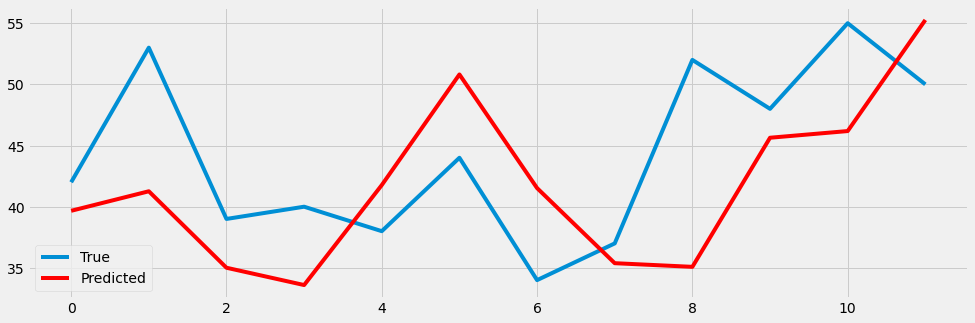

In [99]:
# plot predictions vs expected
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(y) # 真值
plt.plot(yhat, color='red') # 預測值
plt.legend(['True', 'Predicted'])
plt.show()

## 4. Out-of-sample forecast

In [100]:
X_train, y_train = data[:, :-1], data[:, -1] # 全部的數據都拿來 train
print(X_train)
print(y_train)

[[35. 32. 30. 31. 44. 29.]
 [32. 30. 31. 44. 29. 45.]
 [30. 31. 44. 29. 45. 43.]
 ...
 [40. 38. 44. 34. 37. 52.]
 [38. 44. 34. 37. 52. 48.]
 [44. 34. 37. 52. 48. 55.]]
[45. 43. 38. 27. 38. 33. 55. 47. 45. 37. 50. 43. 41. 52. 34. 53. 39. 32.
 37. 43. 39. 35. 44. 38. 24. 23. 31. 44. 38. 50. 38. 51. 31. 31. 51. 36.
 45. 51. 34. 52. 47. 45. 46. 39. 48. 37. 35. 52. 42. 45. 39. 37. 30. 35.
 28. 45. 34. 36. 50. 44. 39. 32. 39. 45. 43. 39. 31. 27. 30. 42. 46. 41.
 36. 45. 46. 43. 38. 34. 35. 56. 36. 32. 50. 41. 39. 41. 47. 34. 36. 33.
 35. 38. 38. 34. 53. 34. 34. 38. 35. 32. 42. 34. 46. 30. 46. 45. 54. 34.
 37. 35. 40. 42. 58. 51. 32. 35. 38. 33. 39. 47. 38. 52. 30. 34. 40. 35.
 42. 41. 42. 38. 24. 34. 43. 36. 55. 41. 45. 41. 37. 43. 39. 33. 43. 40.
 38. 45. 46. 34. 35. 48. 51. 36. 33. 46. 42. 48. 34. 41. 35. 40. 34. 30.
 36. 40. 39. 45. 38. 47. 33. 30. 42. 43. 41. 41. 59. 43. 45. 38. 37. 45.
 42. 57. 46. 51. 41. 47. 26. 35. 44. 41. 42. 36. 45. 45. 45. 47. 38. 42.
 35. 36. 39. 45. 43. 47. 36. 

In [101]:
# build model & fit
model = XGBRegressor(objective='reg:squarederror', # 這個是 loss function
                     n_estimators=1000) # 用多一點的樹才不會 under learning
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [102]:
row = data[-6:, -1] # 因為用 6 個 lags 來預測
# row = row.flatten()
print(row)

[34. 37. 52. 48. 55. 50.]


In [103]:
X_test = np.asarray([row])
print(X_test)

[[34. 37. 52. 48. 55. 50.]]


In [104]:
yhat = model.predict(X_test)
yhat

array([43.697422], dtype=float32)

In [105]:
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [34. 37. 52. 48. 55. 50.], Predicted: 43.697
